In [1]:
import tensorflow as tf
import datetime, os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
import pickle
from tensorflow.keras.optimizers import RMSprop

In [4]:
path = '1661-0.txt'
text = open(path).read().lower()
print('length of the corpus is :', len(text))

length of the corpus is : 581888


In [56]:
tokenizer = RegexpTokenizer('\w+')
words = tokenizer.tokenize(text)

In [57]:
print(words[0:10])

['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur']


In [58]:
unique_words = np.unique(words)
unique_word_index = dict((c,i) for i,c in enumerate(unique_words))

In [59]:
## Feature Engineering
WORD_LENGTH = 5
next_words = []
prev_words = []

for i in range(len(words)-WORD_LENGTH):
    prev_words.append(words[i:i+WORD_LENGTH])
    next_words.append(words[i+WORD_LENGTH])
    
print(prev_words[1])
print(next_words[1])

['gutenberg', 's', 'the', 'adventures', 'of']
sherlock


In [60]:
X = np.zeros((len(prev_words),WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
        Y[i, unique_word_index[next_words[i]]] = 1

In [61]:
#np.zeros((5,5,8), dtype=bool)

In [62]:
#np.zeros((2,8), dtype=bool)

In [63]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [64]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
811/811 [==============================] - 22s 25ms/step - loss: 6.3396 - accuracy: 0.0817 - val_loss: 7.0642 - val_accuracy: 0.1036
Epoch 2/20
811/811 [==============================] - 20s 24ms/step - loss: 5.6324 - accuracy: 0.1479 - val_loss: 7.8930 - val_accuracy: 0.1036
Epoch 3/20
811/811 [==============================] - 20s 24ms/step - loss: 5.6848 - accuracy: 0.1798 - val_loss: 8.1035 - val_accuracy: 0.1071
Epoch 4/20
811/811 [==============================] - 20s 24ms/step - loss: 5.3209 - accuracy: 0.2183 - val_loss: 8.1524 - val_accuracy: 0.0981
Epoch 5/20
811/811 [==============================] - 20s 24ms/step - loss: 4.9983 - accuracy: 0.2606 - val_loss: 8.5687 - val_accuracy: 0.0917
Epoch 6/20
811/811 [==============================] - 20s 24ms/step - loss: 4.7304 - accuracy: 0.3033 - val_loss: 8.7167 - val_accuracy: 0.0925
Epoch 7/20
811/811 [==============================] - 20s 24ms/step - loss: 4.4947 - accuracy: 0.3482 - val_loss: 8.5912 - val_accuracy:

In [65]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

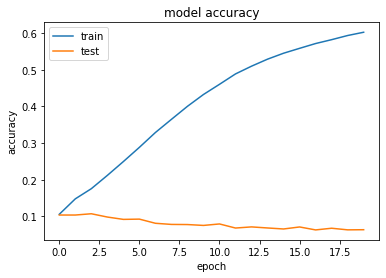

In [66]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

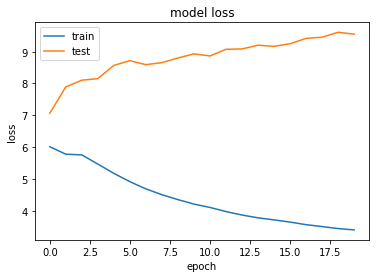

In [67]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [137]:
def prepare_input(text):
    tokens = tokenizer.tokenize(text)
    x = np.zeros((1, len(tokens), len(unique_words)))
    for t, word in enumerate(tokens):
#         print(word, 0, t, unique_word_index[word])
#         if word in unique_word_index:
        x[0, t, unique_word_index[word]] = 1.
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [141]:
indices_char=list(unique_word_index.keys())
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    print(next_indices)
    return [indices_char[idx] for idx in next_indices]

In [145]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages",
    "That which does not kill us makes us stronger",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you",
    "And those who were seen dancing were thought to be insane by those who could not hear the music",
    "It is hard enough to remember my opinions, without also remembering my reasons for them"
]

In [146]:
for q in quotes:
    seq = q.lower()
    print(seq)
    print(predict_completions(seq, 5))

it is not a lack of love, but a lack of friendship that makes unhappy marriages


KeyError: 'marriages'

In [104]:
len(unique_words)

8201

In [107]:
tokenizer.tokenize("it is not a lack of love, but a lack of")

['it', 'is', 'not', 'a', 'lack', 'of', 'love', 'but', 'a', 'lack', 'of']

In [129]:
list(unique_word_index.keys())[4012]

'it'